In [1]:
import sys
import PIL.Image
from PIL import Image
import os
import h5py
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pk
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.utils import get_file

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Input,Add,MaxPool2D,Flatten,AveragePooling2D,Dense,BatchNormalization,ZeroPadding2D,Activation,Concatenate,UpSampling2D
from tensorflow.keras.models import Model

In [3]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [4]:
vgg16 = VGG16(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
resnet = ResNet50(weights='imagenet')
inception = InceptionV3(weights='imagenet')
xception = Xception(weights='imagenet')

In [5]:
def prepare_image_224(img_path):
    img = load_img(img_path, target_size=(224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [6]:
def prepare_image_299(img_path):
    img = load_img(img_path, target_size=(299,299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [7]:
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

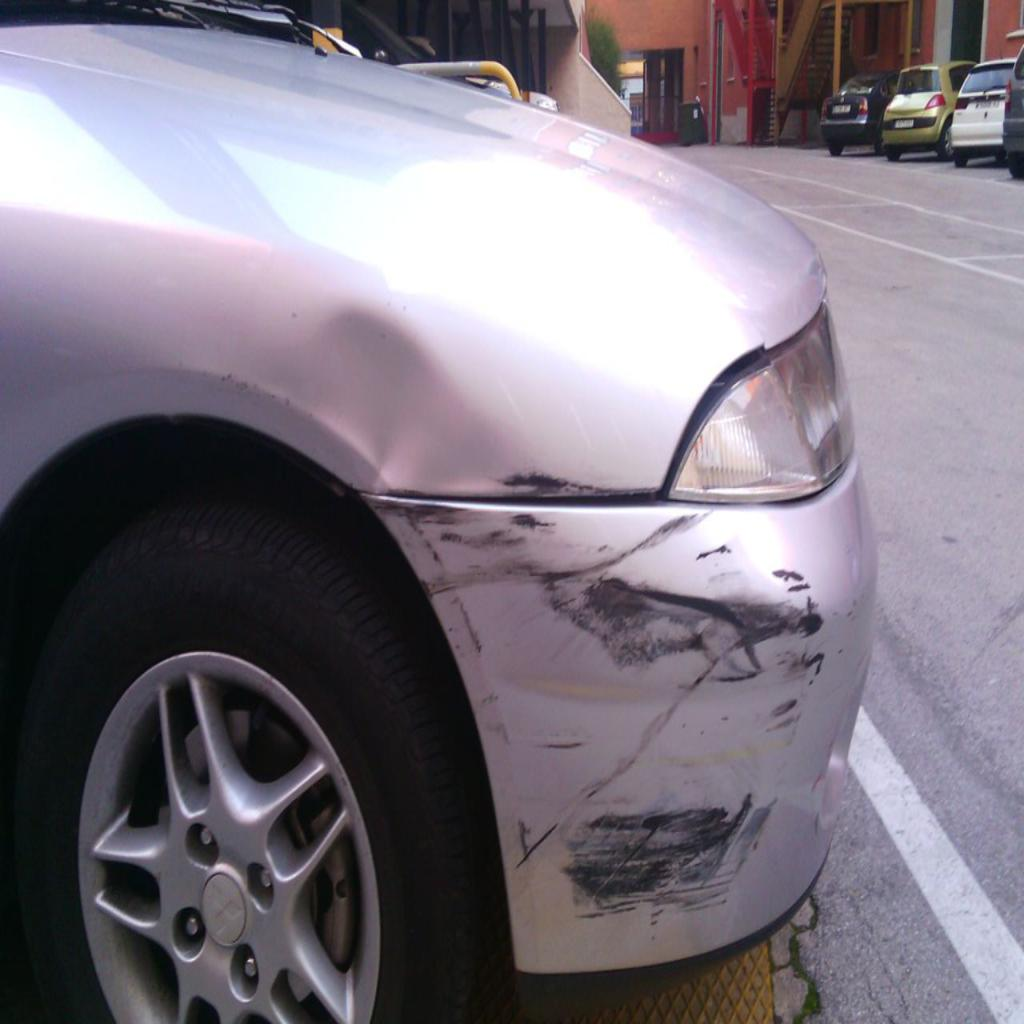

In [8]:
Image('testimage.jpg')

In [9]:
y = prepare_image_224('testimage.jpg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5))

1/1 [==============================] - 1s 616ms/step
[[('n04285008', 'sports_car', 0.3039853), ('n03770679', 'minivan', 0.124912344), ('n02974003', 'car_wheel', 0.106983595), ('n03459775', 'grille', 0.09579371), ('n03100240', 'convertible', 0.08396477)]]


In [10]:
z = prepare_image_224('testimage.jpg')
preds = vgg19.predict(z)
print(get_predictions(preds, top=5))

1/1 [==============================] - 0s 361ms/step
[[('n03770679', 'minivan', 0.6097051), ('n04285008', 'sports_car', 0.18860316), ('n02974003', 'car_wheel', 0.061738443), ('n03459775', 'grille', 0.040662803), ('n03100240', 'convertible', 0.03506931)]]


In [11]:
a = prepare_image_224('testimage.jpg')
preds = resnet.predict(a)
print(get_predictions(preds))

1/1 [==============================] - 1s 1s/step
[[('n02974003', 'car_wheel', 0.23826686), ('n03770679', 'minivan', 0.2308635), ('n02930766', 'cab', 0.106631406), ('n03459775', 'grille', 0.08106575), ('n03930630', 'pickup', 0.06510338)]]


In [12]:
b = prepare_image_299('testimage.jpg')
preds = inception.predict(b)
print(get_predictions(preds, top=5))

1/1 [==============================] - 1s 1s/step
[[('n06359193', 'web_site', 1.0), ('n03047690', 'clog', 1.4700488e-08), ('n04254777', 'sock', 1.43777e-17), ('n04131690', 'saltshaker', 2.43967e-19), ('n01924916', 'flatworm', 6.6457555e-22)]]


In [13]:
c = prepare_image_299('testimage.jpg')
preds = xception.predict(c)
print(get_predictions(preds, top=5))

1/1 [==============================] - 1s 824ms/step
[[('n03942813', 'ping-pong_ball', 0.833602), ('n02115641', 'dingo', 0.16213338), ('n02769748', 'backpack', 0.0018414762), ('n02106662', 'German_shepherd', 0.0017457574), ('n03814906', 'necklace', 0.0005690304)]]


In [14]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('data1')
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('data1/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out,top=5)
        for pred in preds[0]:
            d[pred[0:2]]+=pred[2]
        if(i%50==0):
            print(i,'/',len(img_list),'complete')
    return Counter(d)

In [15]:
categ_count = get_car_categories()

1/1 [==============================] - 0s 164ms/step
0 / 1 complete


In [16]:
with open('vgg16_cat_list.pk', 'wb') as f:
    pk.dump(categ_count, f, -1)

In [17]:
with open('vgg16_cat_list.pk', 'rb') as f:
    categ_count = pk.load(f)

In [18]:
categ_list = [k for k, v in categ_count.most_common()[:50]]

In [19]:
def get_car_categories(categ_list):
    img_list = os.listdir('data1')
    n = 0
    bad_list = []
    for i, img_path in enumerate(img_list):
        img = prepare_image_224('data1/'+img_path)
        out = vgg16.predict(img)
        preds = get_predictions(out, top=5)
        for pred in preds[0]:
            if pred[0:2] in categ_list:
                n+=1
                break
            else:
                pass
            bad_list.append(img_path)
        if i%100 == 0:
            print(i,'/',len(img_list), 'complete')
    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return n, bad_list

In [20]:
num, bad_list = get_car_categories(categ_list)

1/1 [==============================] - 0s 165ms/step
0 / 1 complete


In [21]:
def pipe1(img_path, categ_list):
    urllib.request.urlretrieve(img_path, 'image.jpg')
    img = prepare_image_224('image.jpg')
    out = vgg16.predict(img)
    preds = get_predictions(out, top=5)
    print("Ensuring if the entered picture is a car...")
    for pred in preds[0]:
        if pred[0:2] in categ_list:
            print(pred[0:2])
            return "Successful. Proceeding to damage assessment..."
    return "The entered image is a not a car. Please provide image of a car or try again with different angle"

In [22]:
pipe1('https://tse4.mm.bing.net/th?id=OIP.FaZela57De0uzfVxVY3JJQHaEo&pid=Api&P=0&w=289&h=181', categ_list)

1/1 [==============================] - 0s 209ms/step
Ensuring if the entered picture is a car...
('n04285008', 'sports_car')


'Successful. Proceeding to damage assessment...'

In [23]:
pipe1('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTq7q-pnpeEX0F0xDRqN6csEOfS1z0Ooq7zVKzaOLig&s',categ_list)

1/1 [==============================] - 0s 197ms/step
Ensuring if the entered picture is a car...
('n04285008', 'sports_car')


'Successful. Proceeding to damage assessment...'

In [24]:
pipe1('https://media.istockphoto.com/id/185087000/photo/white-transporter-for-branding.jpg?s=612x612&w=0&k=20&c=yNZxfCE1bTIRkFoNDezW0fN8ukDk-jl59VHoumArfU8=',categ_list)

1/1 [==============================] - 0s 170ms/step
Ensuring if the entered picture is a car...
('n03770679', 'minivan')


'Successful. Proceeding to damage assessment...'

In [25]:
pipe1('https://images.unsplash.com/photo-1591704951890-0862b2e98acb?auto=format&fit=crop&q=80&w=1000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8Ym90dGxlfGVufDB8fDB8fHww',categ_list)

1/1 [==============================] - 0s 219ms/step
Ensuring if the entered picture is a car...


'The entered image is a not a car. Please provide image of a car or try again with different angle'